In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import tensorflow as tf
import tf_wasserstein as twa
from importlib import reload
reload(twa)

<module 'tf_wasserstein' from '/home/user/work_stuff_no_data/ica_wasserstein/tf_wasserstein.py'>

In [2]:
def make_swiss_roll(num_points,radius_scaling=0.0,num_periods=3,z_max=20.0):
    """
    A quick function to generate swiss roll datasets
    
    Inputs:
        num_points - how many data points to output, integer
        radius_scaling - the effective "radius" of the spiral will be increased proportionally to z multiplied by this 
            constant.  Float
        num_periods - the number of rotations around the origin the spiral will form, float
        z_max - the z values of the data will be uniformly distributed between (0,z_max), float
    Outputs:
        data - a tensor of shape (num_points,3)
    """
    
    t = np.linspace(0,num_periods*2.0*np.pi,num_points)
    x = np.cos(t)*t
    y = np.sin(t)*t
    z = np.random.uniform(low=0.0,high=z_max,size=num_points)
    
    x *= (1.0 + radius_scaling*z)
    y *= (1.0 + radius_scaling*z)
    
    data = np.stack([x,y,z],axis=1)
    
    return data

In [182]:
#some example data, small enough to run on a laptop
num_points = 10000
data = make_swiss_roll(num_points,num_periods=2)

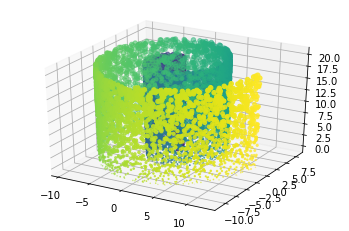

In [183]:
#let's plot this and see what it looks like in 3 dimensions
fig = plt.figure()
ax = fig.gca(projection='3d')
spiral_color = np.linspace(0,10,num_points) #for plotting purposes
size_vals = np.copy(data[:,2]) #will be useful when we plot latent variables
ax.scatter(data[:,0],data[:,1],data[:,2],c=spiral_color,s=size_vals)
plt.show()

In [184]:
full_batch,D = data.shape

We are going to build and optimize a sinkhorn autoencoder, and work within TensorFlow 2's eager framework.  First we are going to build some encoder and decoder networks, then define some losses on them, and finally set up a training loop.

In [185]:
#let's define some dimensions
x_D = D
y_D = 2

In [186]:
#the encoder will be an MLP with two hidden layers
encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(50,activation='relu',input_shape=(x_D,)),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(y_D)
])

#the decoder will be roughly the same
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(50,activation='relu',input_shape=(y_D,)),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(x_D)
])

In [187]:
vars_to_train = encoder.trainable_variables + decoder.trainable_variables

In [188]:
len(vars_to_train)

12

In [189]:
#a cell for hyper parameters
num_training_steps = 100
batch_size = 256
#we're going to use fixed values for the sinkhorn loss hyperparameters, though with sinkhorn loss this is not strictly necessary
epsilon = 0.001
num_iterates = 40
#a weighting factor for the reconstructions vs sinkhorn loss
beta = 0.1

In [190]:
#we're going to use ADAM to optimize
optimizer = tf.keras.optimizers.Adam()

In [191]:
#to hold trajectories of the loss function
sinkhorn_loss_history = []
reconstruction_loss_history=[]
full_loss_history = []


In [192]:
#this is the part where we compute the forward pass and compute the loss
for step in range(10*num_training_steps):
    #we have to create auxillary data for the sinkhorn loss
    y_noise = np.random.uniform(low=-1.0,high=1.0,size=(batch_size,y_D)).astype(np.float32)
    
    #we will randomly take a batch of samples without replacement
    indices = np.random.choice(full_batch,size=batch_size,replace=False)
    training_batch = data[indices,:]
    with tf.GradientTape() as tape:
        y = encoder(training_batch.astype(np.float32))
        sinkhorn_loss = twa.sinkhorn_loss(y,y_noise,epsilon,batch_size,num_iterates)
        x_hat = decoder(y)
        reconstruction_loss = tf.reduce_mean( tf.losses.mean_squared_error(training_batch,x_hat) )
        full_loss = sinkhorn_loss + beta*reconstruction_loss
    sinkhorn_loss_history.append(sinkhorn_loss)
    reconstruction_loss_history.append(reconstruction_loss)
    full_loss_history.append(full_loss.numpy())
    grads = tape.gradient(full_loss,vars_to_train)
    optimizer.apply_gradients(zip(grads,vars_to_train))
    if step % 10 == 0:
        print("done with step {}".format(len(full_loss_history)))

done with step 1
done with step 11
done with step 21
done with step 31
done with step 41
done with step 51
done with step 61
done with step 71
done with step 81
done with step 91
done with step 101
done with step 111
done with step 121
done with step 131
done with step 141
done with step 151
done with step 161
done with step 171
done with step 181
done with step 191
done with step 201
done with step 211
done with step 221
done with step 231
done with step 241
done with step 251
done with step 261
done with step 271
done with step 281
done with step 291
done with step 301
done with step 311
done with step 321
done with step 331
done with step 341
done with step 351
done with step 361
done with step 371
done with step 381
done with step 391
done with step 401
done with step 411
done with step 421
done with step 431
done with step 441
done with step 451
done with step 461
done with step 471
done with step 481
done with step 491
done with step 501
done with step 511
done with step 521
done

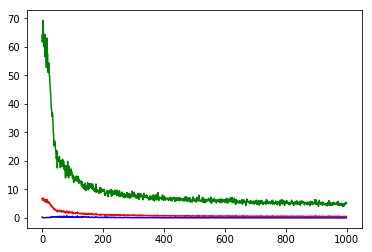

In [193]:
plt.plot(full_loss_history,'r')
plt.plot(sinkhorn_loss_history,'b')
plt.plot(reconstruction_loss_history,'g')
plt.show()

In [194]:
#let's visualize the full data set after being mapped into latent space by the encoder
y_full = encoder(data.astype(np.float32))

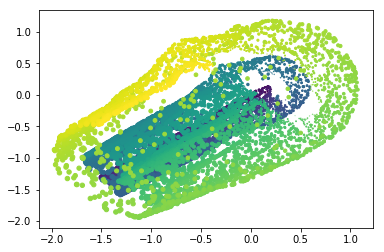

In [195]:
plt.scatter(y_full[:,0],y_full[:,1],c=spiral_color,s=size_vals)
plt.show()

Note that one axis in the latent space roughly corresponds to the z-axis of the original space, and the other axis roughly encodes spiral position

In [196]:
#let's also plot the reconstructions
x_hat_full = decoder(y_full)

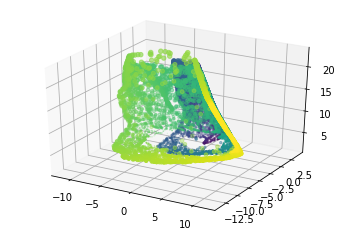

In [197]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x_hat_full[:,0],x_hat_full[:,1],x_hat_full[:,2],c=spiral_color,s=size_vals)
plt.show()